In [1]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')

my_path = '/content/notebooks'

# Colab Notebooks 안에 local_packages 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/local_packages', my_path)
sys.path.insert(0, my_path)

Mounted at /content/drive


# Word2Vec Review

- 비지도 학습법.
  - 문장 안에서 근처 단어들을 통해 target 학습.
- 임베딩을 통해 단어 벡터화, 단어 벡터들을 통해 연관 학습
- skip-gram(중심 단어를 기준으로 주변 단어 예측)과 CBOW(주변 단어를 기준으로 중심 단어 예측) 2가지의 단어 벡터 계산 방법.

# Doc2Vec

<br>

- Word2Vec에 기초한 모형.
    - Paragraph ID라는 입력 벡터를 하나 더 추가.
    - 문서 자체를 훈련 데이터로 사용.

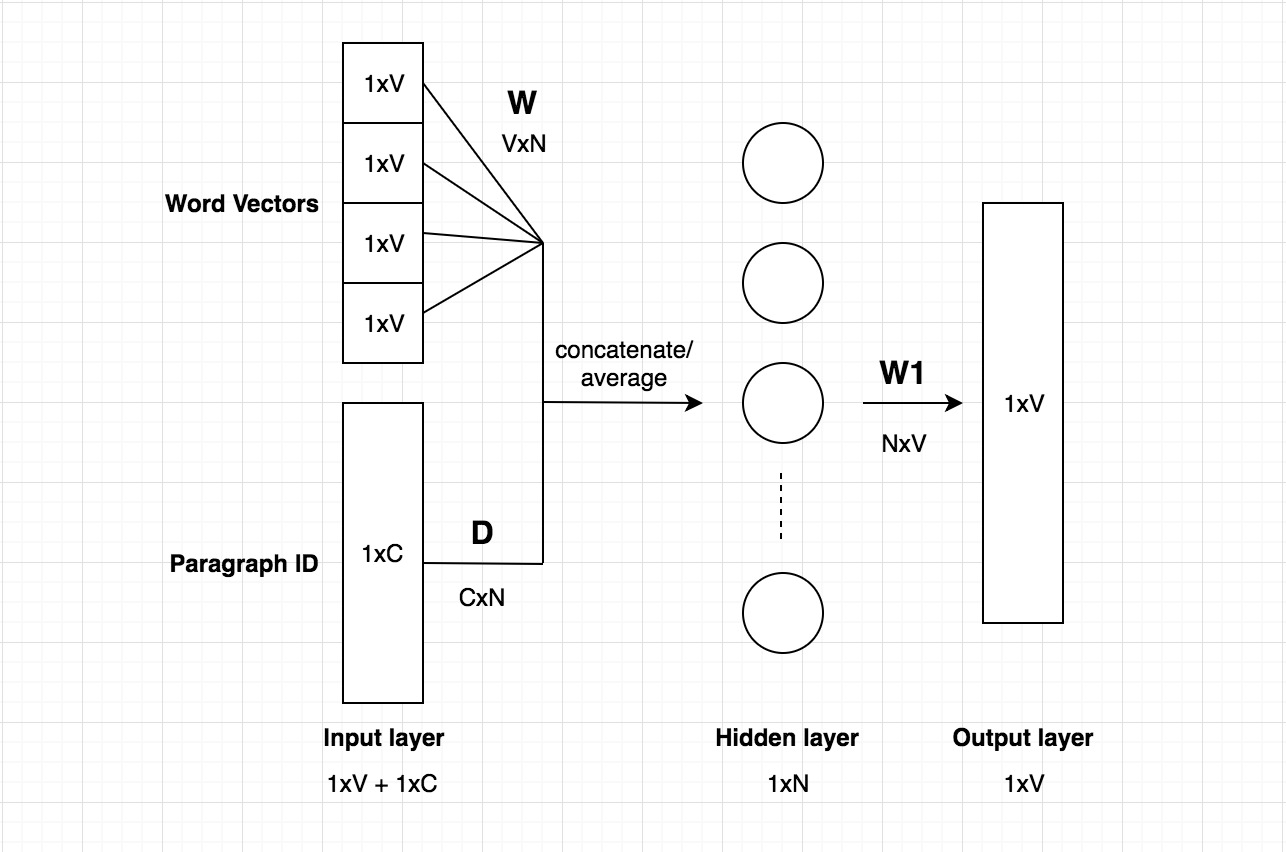

- doc2vec의 **PV-DM(distributed Memory version of Paragraph Vector)**모형. 
- word2vec의 CBOW 모델에 **document-unique한 특징 벡터를 하나 더 추가**함. D.
     - 단어 벡터 W를 훈련함과 동시에 문서 ID벡터 D 또한 훈련 됨.
     - 훈련 종료 후, 문서 ID벡터 D는 문서의 수치적 표현을 담고있게 됨.
- 입력으로 단어 벡터와 문서 ID 벡터를 받고있음.
    - 단어 벡터는 1 * V 크기의 one-hot vector.
    - 문서 ID 벡터는 1 * C (C : 총 문서의 갯수) 크기의 벡터.
- 은닉층은 1 * N 크기.
    - 단어 벡터에 대한 가중 행렬 W는 V * N 크기.
    - 문서 ID벡터에 대한 가중 행렬 D는 C * N 크기.
    
------------------

- 문서 ID벡터와 앞의 단어들을 사용해 다음에 나오는 단어를 예측.

## PV-DM (Distributed Memory Model)

<br>

- Word2Vec의 CBOW 모형과 유사.
- 주변 단어 벡터 + 문서 ID벡터를 입력으로 받아 중심 단어 예측.

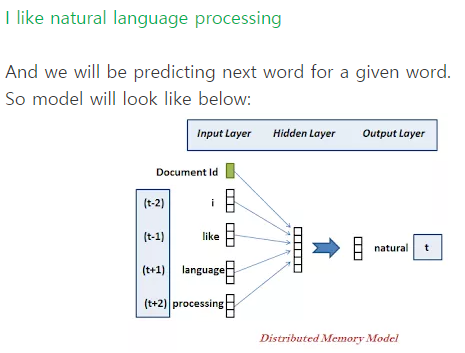


## PV-DBOW (Distributed Bag of Words)

<br>

- Word2Vec의 Skip-gram 모형과 유사.
- 중심 단어를 기준으로 주변 단어를 예측 하는 것이 아닌, 문서 벡터 ID를 입력으로 받아,
- 문서에서 randomly sample 된 단어들을 예측함.

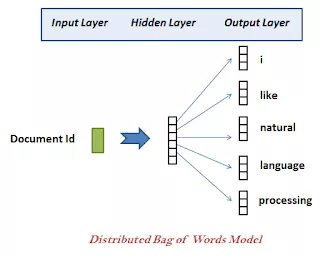

# Korean Example (네이버 영화 리뷰)

In [2]:
import pandas as pd
import urllib.request
from gensim.models.doc2vec import TaggedDocument
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", 
                           filename="ratings.txt")

train_data = pd.read_table('ratings.txt')

In [5]:
# 간단한 전처리
# 이전 예제랑 동일하게

train_data = train_data.dropna(how='any')
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 토큰화 작업
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

C:\Users\CHEOLH~1\AppData\Local\Temp/ipykernel_22656/426663760.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')


In [6]:
tokenized_data[:2]

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'],
 ['디자인',
  '을',
  '배우다',
  '학생',
  '외국',
  '디자이너',
  '그',
  '일군',
  '전통',
  '을',
  '통해',
  '발전',
  '문화',
  '산업',
  '부럽다',
  '사실',
  '우리나라',
  '에서도',
  '그',
  '어려운',
  '시절',
  '끝',
  '까지',
  '열정',
  '을',
  '지키다',
  '노라노',
  '같다',
  '전통',
  '있다',
  '저',
  '같다',
  '사람',
  '꿈',
  '을',
  '꾸다',
  '이루다',
  '갈수',
  '있다',
  '감사하다']]

In [9]:
# 학습하기 위해서는 list of str (like) 구조의 input 이 필요.
# 한 문장 단위로 스냅샷을 만들기 때문.
from gensim.models import Doc2Vec

model = Doc2Vec(
    # documents = ,
    corpus_file = tokenized_data,
    vector_size = 100,
    window = 5,
    workers = 4
)

TypeError: stat: path should be string, bytes, os.PathLike or integer, not list

In [10]:
from gensim.models.doc2vec import TaggedDocument

class Doc2VecCorpus:
    def __init__(self, fname):
        self.fname = fname
    def __iter__(self):
        with open(self.fname, encoding='UTF-8') as f:
            for doc in f:
                movie_index, text = doc.split('\t')
                yield TaggedDocument(
                    words = text.split(),
                    tags = ['MOVIE %s' % movie_index]
                )

doc2vec_corpus = Doc2VecCorpus('ratings.txt')

In [11]:
from gensim.models import Doc2Vec

model = Doc2Vec(doc2vec_corpus)

ValueError: too many values to unpack (expected 2)